## Import packages

In [91]:
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
import random
import json
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

import seaborn as sns
import matplotlib.pyplot as plt
# sns.set(style="darkgrid")



## Read CSV, Split train-test

In [92]:
import spacy

nlp = spacy.load("en_core_web_sm")
def count_words(text):
  tokens = [word.text for word in nlp(text)]
  return len(tokens)

In [94]:
# (a['data'][0]['paragraphs'])[0]

In [95]:
# # !python3 -m spacy download en_core_web_sm

# a = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/bioasq/train_bioasq_9B_with_label.json'))
# a = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/emrqa/datasets/relation-train-sampled-0.03.json'))
# a = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/squad/train_squad.json'))


# # df = pd.DataFrame()
# # df['context'] = [x['context'] for x in a['data'][0]['paragraphs']]
# # df['question'] = [x['qas'][0]['question'] for x in a['data'][0]['paragraphs']]
# # df['answer'] = [x['qas'][0]['answers'][0]['text'] for x in a['data'][0]['paragraphs']]

# df = pd.DataFrame()
# df['context'] = [y['context'] for x in a['data'] for y in x['paragraphs'] for z in y['qas']]
# df['question'] = [z['question'] for x in a['data'] for y in x['paragraphs'] for z in y['qas']]
# df['answer'] = [z['answers'][0]['text'] for x in a['data'] for y in x['paragraphs'] for z in y['qas']]

In [96]:
# (a['data'][0]['paragraphs'][0]['qas'])

# df

In [60]:
# len(np.unique(df['context'].values))/len(np.unique(df['answer'].values))
# len(np.unique(df['context'].values)), len(np.unique(df['question'].values))

In [97]:
df = pd.read_csv('../data/otquad-v1.0 - Sheet1.csv')[['title', 'context',
                                                      'question', 'answer']]
df = df.sample(frac=1).reset_index(drop=True)

print(len(df))
print(f"Number of Unique Contexts   : {df['context'].nunique()}")
print(f"Ratio of QA Pair-to-Context : {len(df)/df['context'].nunique()}")

df['context_length'] = df['context'].apply(count_words)
df['question_length'] = df['question'].apply(count_words)
df['answer_length'] = df['answer'].apply(count_words)


1097
Number of Unique Contexts   : 190
Ratio of QA Pair-to-Context : 5.773684210526316


In [ ]:
# dff = df.sample(100, random_state=42)
# dff.to_csv('../data/sample_data.csv', index=False)

In [ ]:
# df

In [14]:
# df_copy = deepcopy(df)
# df_copy.drop_duplicates(subset='context', keep="last", inplace = True)
# df_copy.reset_index(drop=True)

# n = 38
# test_fold_lists  = [df_copy.iloc[n*(ct-1):n*ct] for ct in range(1,6)]
# train_fold_lists = []
# for i in range(5):
#   a_index = df_copy.set_index(df_copy.columns.tolist()).index
#   b_index = test_fold_lists[i].set_index(df_copy.columns.tolist()).index
#   mask = ~a_index.isin(b_index)
#   result = df_copy.loc[mask]
#   train_fold_lists.append(result)

# train_list, test_list = [], []
# for i in range(5):
#   train = pd.merge(train_fold_lists[i], df, on="context")
#   test = pd.merge(test_fold_lists[i], df, on="context")
#   train_list.append(train)
#   test_list.append(test)

In [15]:
# for x in test_fold_lists:
#   print(x.shape)

In [16]:
# for x in train_fold_lists:
#   print(x.shape)

In [17]:
# train_fold_lists[1]

In [18]:
# test_fold_lists[0]

In [19]:
def df_to_json(df, data_path, json_filename):
  start_index = [df['context'].values[i].lower().find(df['answer_y'].values[i].lower())
                 for i in range(len(df))]
  df['start_index_y'] = start_index

  print(df.shape)
  
  for i in range(len(df)):
#       print(i, start_index[i])
#       print('Original : ',df['answer_y'].values[i].lower())
#       print('Extracted: ', df['context'].values[i].lower()[start_index[i]:start_index[i]+len(df['answer_y'].values[i])])
      assert df['answer_y'].values[i].lower() == df['context'].values[i].lower()[
        start_index[i]:start_index[i]+len(df['answer_y'].values[i])]

  print(f'Unique Contexts: {len(np.unique(df.context.values))}\n Ratio of QA Pair-to-Contexts: {len(df)/len(np.unique(df.context.values))}')

  squad_entries= []
  for i in tqdm(range(len(df))):
    id_num      = i
    context     = df['context'].values[i]
    question    = df['question_y'].values[i]
    answer_text = df['answer_y'].values[i]
    start       = df['start_index_y'].values[i]
    title       = df['title_y'].values[i]

    if start!=-1:
      answer={"text":answer_text,"answer_start":int(start)}
    else:
      continue
    new_entry={
               "qas": [
                 {
                  "id": int(id_num),
                  "question": question,
                  "answers": [answer]
                 }
                 ],
               "context": context
               }
    squad_entries.append({"title":title,
                          "paragraphs":[new_entry]})
        

  squad_json={"data": squad_entries,
            "version":1.0}

#   with open(data_path/json_filename, "w") as writer:
#       writer.write(json.dumps(squad_json, indent=4) + "\n")



In [ ]:
# df_to_json(df, data_path, f'otquad.json')


In [20]:
# data_path = Path('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/otquad/')
# # data_path = Path('../data/')
# for i in range(5):
#   print(i)
#   assert train_list[i].shape[0]+test_list[i].shape[0]==1097
#   print(len(set(train_list[i+1]['context'].values.tolist()).intersection(
#     set(test_list[i]['context'].values.tolist()))))
#   df_to_json(train_list[i], data_path, f'train_otquad_fold_{i+1}.json')
#   df_to_json(test_list[i], data_path, f'test_otquad_fold_{i+1}.json')

In [ ]:
# for i in range(10):
#   print(test_list[i].shape)

In [ ]:
# print('Train total length: ', len(train))
# print('Test total length: ', len(test))


## Plot q-type frequency

In [ ]:
# a = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/otquad/otquad.json'))

# questions = []
# contexts  = []
# answers   = []
# idxs      = []
# for d in a['data']:
#   for p in d['paragraphs']:
#     for qa in p['qas']:
#       idxs.append(qa['id'])
#       questions.append(qa['question'])
#       answers.append(qa['answers'][0]['text'])
#       contexts.append(p['context'])
    
# print(len(contexts))
# print(len(np.unique(contexts)))

In [ ]:
# df_squad = pd.DataFrame()
# df_squad['question'] = questions
# df_squad['answer'] = answers
# df_squad['context'] = contexts

# df_squad['context_length'] = df_squad['context'].apply(len)
# df_squad['question_length'] = df_squad['question'].apply(len)
# df_squad['answer_length'] = df_squad['answer'].apply(len)

In [23]:
# get_qtype_freq(df)

In [24]:
def get_qtype_freq(df):
  q_list = df['question'].values.tolist()
  q_type = ['what', 'when', 'where', 'who', 'whom', 
            'which', 'why', 'how'] #, 'name', 'whose', 
  
  q_freq = {}
  for ques in q_list:
    q_tokens = ques.lower().split()
    for typ in q_type:
      if typ in q_tokens[0]:
        q_freq.setdefault(typ, []).append(ques)

  freq_qtype = [len(x) for x in list(q_freq.values())]
  print(freq_qtype, sum(freq_qtype))
  
  df_sorted = pd.DataFrame()
  df_sorted['QTYPE'] = list(q_freq.keys())
  df_sorted['QFREQ'] = freq_qtype
  df_sorted['n'] = freq_qtype
  df_sorted = df_sorted.sort_values("QFREQ", ascending=False)

  print(df_sorted.shape)
  
  return df_sorted
  

In [25]:
def plot_qtype_frequency(df_sorted, dataset_name):
  
  # Values for the x axis
  ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(df_sorted), endpoint=False)

  # Cumulative length
  QFREQ = df_sorted["QFREQ"].values

  # # Mean gain length
  # MEAN_GAIN = df_sorted["mean_gain"].values

  # Region label
  QTYPE = df_sorted["QTYPE"].values

  # Number of tracks per region
  N = df_sorted["n"].values

  GREY12 = "#1f1f1f"

  # Set default font color to GREY12
  plt.rcParams["text.color"] = GREY12

  # The minus glyph is not available in Bell MT
  # This disables it, and uses a hyphen
  plt.rc("axes", unicode_minus=False)

  # Colors
  COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195"]

  # Colormap
  cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)

  # Normalizer
  norm = mpl.colors.Normalize(vmin=N.min(), vmax=N.max())

  # Normalized colors. Each number of tracks is mapped to a color in the 
  # color scale 'cmap'
  COLORS = cmap(norm(N))

  # Some layout stuff ----------------------------------------------
  # Initialize layout in polar coordinates
  fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": "polar"})

  # Set background color to white, both axis and figure.
  # fig.patch.set_facecolor("white")
  # ax.set_facecolor("white")

  ax.set_theta_offset(100 * np.pi / 3)
  ax.set_ylim(-100, 350)

  # Add geometries to the plot -------------------------------------
  # See the zorder to manipulate which geometries are on top

  # Add bars to represent the cumulative track lengths
  ax.bar(ANGLES, QFREQ, color=COLORS, alpha=1, width=0.6, zorder=11) #, ls=(0, (4, 4))

  # Add dashed vertical lines. These are just references
  ax.vlines(ANGLES, 0, 350, alpha=0.5, color=GREY12, zorder=11)

  # # Add dots to represent the mean gain
  # ax.scatter(ANGLES, MEAN_GAIN, s=60, color=GREY12, zorder=11)

  # Add labels for the regions -------------------------------------
  # Note the 'wrap()' function.
  # The '5' means we want at most 5 consecutive letters in a word, 
  # but the 'break_long_words' means we don't want to break words 
  # longer than 5 characters.
  QTYPE = ["\n".join(wrap(r, 5, break_long_words=False)) for r in QTYPE]

  # Set the labels
  ax.set_xticks(ANGLES)
  ax.set_xticklabels(QTYPE, size=15);

  plt.show()
  
#   sns.set(style="whitegrid")
  colors = sns.color_palette('pastel')[0:len(df_sorted)]

  plt.subplots(figsize=(8, 15))
  explode = (0, 0.02, 0.03, 0.05, 0.1, 0.15, 0.4, 0.6)
  plt.pie(df_sorted['QFREQ'].values, labels=df_sorted['QTYPE'].values,
          explode=explode, colors = colors, autopct='%1.1f%%', shadow=False,
          textprops={'fontsize': 15})
  plt.xticks(size=25)
#   plt.title(f"Distribution of question types in {dataset_name}", size=15)
  plt.show()


In [26]:
def density_plot_data(df, col_name_list, which_attr, dataset_name, x1limit, x2limit, figsize=(6,4)):
  plt.figure(figsize=figsize)
  for col_name in col_name_list:
    print(len(df[col_name]))
    fig = sns.kdeplot(df[col_name], shade=True, label = col_name)
  plt.xlim(x1limit, x2limit)
  plt.xticks(size=14)
  plt.yticks(size=14)
  plt.xlabel('Length', size=15)
  plt.ylabel('Density\n', size=15)
  plt.legend(loc='best', fontsize=14)
#   plt.title(f"Distribution of '{which_attr}'\nin {dataset_name}", size=15)
  plt.show()

In [27]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'cpgQA' + color.END)

cpgQA


[61, 76, 578, 92, 70, 14, 28, 2] 921
(8, 3)


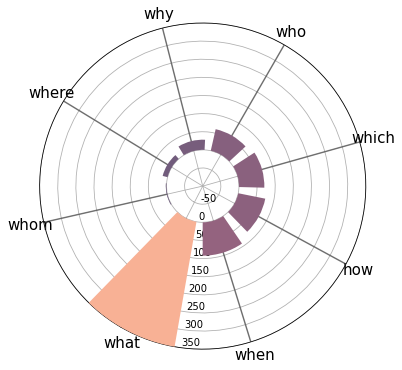

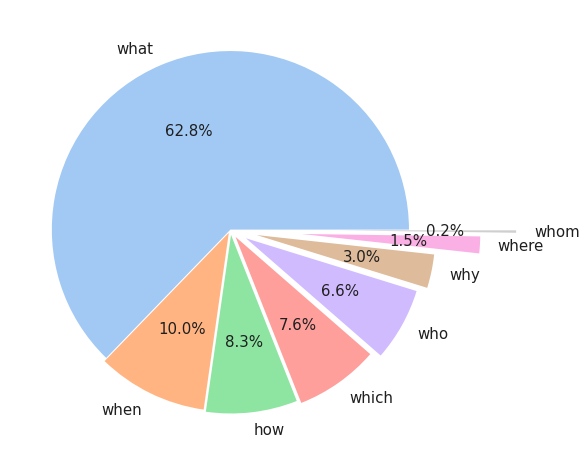

In [28]:
df_sorted = get_qtype_freq(df)
plot_qtype_frequency(df_sorted, 'cpgQA')

In [29]:
# density_plot_data(df, ['context_length'], 'context length', 'OTQuAD', -50, 750, figsize=(6,4))
# density_plot_data(df, ['question_length', 'answer_length'], 'question and answer length', 'OTQuAD', -10, 100, figsize=(6,4))


In [30]:
# import seaborn as sns
# iris = sns.load_dataset("iris")
# ax = sns.boxplot(data=iris, orient="h", palette="Set2")

In [31]:
new_title = {'Discussion of Recommendations: Risk Mitigation: Recommendation':'Recommendations',
 'Discussion of Recommendations: Risk Mitigation: Discussion: Written Informed Consent and Opioid Treatment Agreements \n':'Recommendations',
 'Discussion of Recommendations: Opioid Therapy for Acute Pain: Discussion':'Recommendations',
 'Discussion of Recommendations: Risk Mitigation: Discussion: Prescribing of Naloxone Rescue and Accompanying Education':'Recommendations',
 'Discussion of Recommendations: Opioid Therapy for Acute Pain: Recommendation':'Recommendations',
 'Recommendations':'Recommendations',
 'About this Clinical Practice Guideline: Shared Decision Making': 'Specifications',
 'Discussion of Recommendations: Initiation and Continuation of Opioids: Recommendation \n':'Recommendations',
 'Introduction' : 'Introduction',
 'Discussion of Recommendations: Risk Mitigation: Discussion: Other Risk Mitigation Strategies':'Recommendations',
 'Paradigm Shift in Pain and Its Treatment':'Background',
 'Discussion of Recommendations: Type, Dose, Duration, Follow-up, and Taper of Opioids: Recommendations':'Recommendations',
 'Epidemiology and Impact: General Population':'Background',
 'Discussion of Recommendations: Risk Mitigation: Discussion':'Recommendations',
 'About this Clinical Practice Guideline: Methods': 'Specifications',
 'Opioid Epidemic':'Background',
 'Discussion of Recommendations: Initiation and Continuation of Opioids: Discussion \n':'Recommendations',
 'Module C: Tapering or Discontinuation of Opioid Therapy': 'Algorithm',
 'Discussion of Recommendations: Type, Dose, Duration, Follow-up, and Taper of Opioids: Discussion':'Recommendations',
 'Discussion of Recommendations: Risk Mitigation: Discussion: State Prescription Drug Monitoring Programs':'Recommendations',
 'Discussion of Recommendations: Initiation and Continuation of Opioids: Recommendations \n':'Recommendations',
 'How to Use This Clinical Practice Guideline': 'Introduction',
 'Chronic Pain and Co-occurring Conditions ':'Background',
 'Discussion of Recommendations: Risk Mitigation: Discussion: Patients at High Risk for Opioid Use Disorder':'Recommendations',
 'Module A: Determination of Appropriateness for Opioid Therapy': 'Algorithm',
 'Risk Factors for Adverse Outcomes of Opioid Therapy ':'Background',
 'Taxonomy':'Background',
 'About this Clinical Practice Guideline': 'Specifications',
 'About this Clinical Practice Guideline: Patient-centered Care': 'Specifications',
 'Pain Management Opioid Taper Decision Tool': 'Specifications',
 'Prioritizing Safe Opioid Prescribing Practices and Use ':'Background',
 'Discussion of Recommendations: Initiation and Continuation of Opioids: Discussion':'Recommendations',
 'Significant Risk Factors':'Background',
 'About this Clinical Practice Guideline: Clinical Decision Support Tools': 'Specifications',
 'Qualifying Statements':'Introduction',
 'Module D: Patients Currently on Opioid Therapy': 'Algorithm',
 'Mental health disorders':'Background',
 'Discussion of Recommendations: Risk Mitigation: Discussion: Urine Drug Testing and Confirmatory Testing':'Recommendations',
 'Discussion of Recommendations: Initiation and Continuation of Opioids: Recommendation':'Recommendations',
 'About this Clinical Practice Guideline: Scope of this Clinical Practice Guideline': 'Specifications',
 'Algorithm': 'Algorithm',
 'Module B: Treatment with Opioid Therapy': 'Algorithm',
 'About this Clinical Practice Guideline: Highlighted Features of this Clinical Practice Guideline': 'Specifications',
 'Epidemiology and Impact: VA/DoD Population ': 'Background'}


In [32]:
df['title_new'] = df['title'].map(new_title)
df['title_new'].value_counts()

Recommendations    411
Specifications     280
Background         233
Algorithm          129
Introduction        44
Name: title_new, dtype: int64

In [33]:
# df_con = pd.DataFrame()
# df_con['length'] = df['context_length']
# df_con['which'] = ['context_length']*df_con.shape[0]

# df_ans = pd.DataFrame()
# df_ans['length'] = df['answer_length']
# df_ans['which'] = ['answer_length']*df_ans.shape[0]

# df_que = pd.DataFrame()
# df_que['length'] = df['question_length']
# df_que['which'] = ['question_length']*df_que.shape[0]


In [34]:
# df_len = pd.DataFrame()
# df_len = df_len.append(df_con)
# df_len = df_len.append(df_que)
# df_len = df_len.append(df_ans)

# df_len

In [98]:
# df_len = pd.DataFrame()
# df_len['Context'] = df['context_length']
# df_len['Question'] = df['question_length']
# df_len['Answer'] = df['answer_length']

# df_len.describe()

,Context,Question,Answer
count,1097.000000,1097.000000,1097.000000
mean,201.388332,14.437557,13.661805
std,130.458192,7.334299,16.077865
min,28.000000,4.000000,1.000000
25%,108.000000,9.000000,4.000000
50%,173.000000,12.000000,8.000000
75%,247.000000,18.000000,17.000000
max,662.000000,60.000000,183.000000


In [67]:
df_len = pd.DataFrame()
df_len['Context'] = df['context_length']
df_len['Question'] = df['question_length']
df_len['Answer'] = df['answer_length']


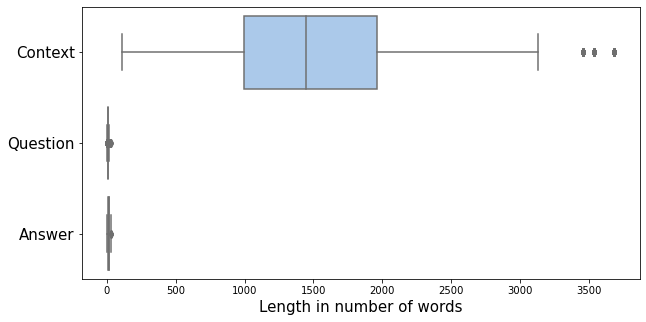

In [90]:
plt.subplots(figsize=(10, 5))
fig = sns.boxplot(data=df_len, orient="h", palette="pastel")
# plt.xlim(-5, 430)
# plt.xticks(range(0, 430, 25), size=12)
plt.yticks(size=15)
plt.xlabel('Length in number of words', size=15)
# plt.ylabel('Density\n', size=18)
#   plt.title(f"Distribution of '{which_attr}'\nin {dataset_name}", size=15)
plt.show()

In [69]:
df_len.describe()

,Context,Question,Answer
count,87599.000000,87599.000000,87599.000000
mean,140.277606,11.402824,3.480850
std,57.937860,3.775971,3.871939
min,22.000000,1.000000,1.000000
25%,103.000000,9.000000,1.000000
50%,129.000000,11.000000,2.000000
75%,167.000000,13.000000,4.000000
max,809.000000,60.000000,46.000000


In [102]:
a = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/bioasq/test_bioasq9b.json'))
# a = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/emrqa/datasets/relation-train-sampled-0.03.json'))
# a = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/squad/train_squad.json'))


df = pd.DataFrame()
df['context'] = [x['context'] for x in a['data'][0]['paragraphs']]
df['question'] = [x['qas'][0]['question'] for x in a['data'][0]['paragraphs']]
df['answer'] = [x['qas'][0]['answers'][0]['text'] for x in a['data'][0]['paragraphs']]

print(len(df))
print(f"Number of Unique Contexts   : {df['context'].nunique()}")
print(f"Ratio of QA Pair-to-Context : {len(df)/df['context'].nunique()}")

df['context_length'] = df['context'].apply(count_words)
df['question_length'] = df['question'].apply(count_words)
df['answer_length'] = df['answer'].apply(count_words)

df_len = pd.DataFrame()
df_len['Context'] = df['context_length']
df_len['Question'] = df['question_length']
df_len['Answer'] = df['answer_length']

df_len.describe()

937
Number of Unique Contexts   : 930
Ratio of QA Pair-to-Context : 1.0075268817204301


,Context,Question,Answer
count,937.000000,937.000000,937.000000
mean,35.783351,10.312700,1.692636
std,30.653304,3.665993,1.413261
min,4.000000,4.000000,1.000000
25%,20.000000,7.000000,1.000000
50%,29.000000,9.000000,1.000000
75%,42.000000,12.000000,2.000000
max,287.000000,24.000000,23.000000


In [99]:
# a = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/bioasq/train_bioasq_9B_with_label.json'))
a = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/emrqa/datasets/relation-dev.json'))
# a = json.load(open('/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/squad/train_squad.json'))


# df = pd.DataFrame()
# df['context'] = [x['context'] for x in a['data'][0]['paragraphs']]
# df['question'] = [x['qas'][0]['question'] for x in a['data'][0]['paragraphs']]
# df['answer'] = [x['qas'][0]['answers'][0]['text'] for x in a['data'][0]['paragraphs']]

df = pd.DataFrame()
df['context'] = [y['context'] for x in a['data'] for y in x['paragraphs'] for z in y['qas']]
df['question'] = [z['question'] for x in a['data'] for y in x['paragraphs'] for z in y['qas']]
df['answer'] = [z['answers'][0]['text'] for x in a['data'] for y in x['paragraphs'] for z in y['qas']]


print(len(df))
print(f"Number of Unique Contexts   : {df['context'].nunique()}")
print(f"Ratio of QA Pair-to-Context : {len(df)/df['context'].nunique()}")

df['context_length'] = df['context'].apply(count_words)
df['question_length'] = df['question'].apply(count_words)
df['answer_length'] = df['answer'].apply(count_words)

df_len = pd.DataFrame()
df_len['Context'] = df['context_length']
df_len['Question'] = df['question_length']
df_len['Answer'] = df['answer_length']

df_len.describe()

80405
Number of Unique Contexts   : 41
Ratio of QA Pair-to-Context : 1961.0975609756097


,Context,Question,Answer
count,80405.000000,80405.000000,80405.000000
mean,1508.810870,8.111262,11.520154
std,700.251123,2.643020,6.327157
min,107.000000,1.000000,1.000000
25%,1096.000000,7.000000,6.000000
50%,1449.000000,8.000000,11.000000
75%,1669.000000,10.000000,16.000000
max,2866.000000,28.000000,31.000000


In [ ]:
# # test sets

# # emrqa
# Context	Question	Answer
# count	80405.000000	80405.000000	80405.000000
# mean	1508.810870	8.111262	11.520154
# std	700.251123	2.643020	6.327157
# min	107.000000	1.000000	1.000000
# 25%	1096.000000	7.000000	6.000000
# 50%	1449.000000	8.000000	11.000000
# 75%	1669.000000	10.000000	16.000000
# max	2866.000000	28.000000	31.000000

# # bioasq
# 	Context	Question	Answer
# count	937.000000	937.000000	937.000000
# mean	35.783351	10.312700	1.692636
# std	30.653304	3.665993	1.413261
# min	4.000000	4.000000	1.000000
# 25%	20.000000	7.000000	1.000000
# 50%	29.000000	9.000000	1.000000
# 75%	42.000000	12.000000	2.000000
# max	287.000000	24.000000	23.000000

In [ ]:
# bioasq
# 	Context	Question	Answer
# count	13178.000000	13178.000000	13178.000000
# mean	284.015708	10.865002	2.686295
# std	113.576309	3.907588	3.809507
# min	9.000000	3.000000	1.000000
# 25%	217.000000	8.000000	1.000000
# 50%	274.000000	10.000000	1.000000
# 75%	330.000000	13.000000	3.000000
# max	3191.000000	30.000000	53.000000


# emrqa
# 	Context	Question	Answer
# count	18056.000000	18056.000000	18056.000000
# mean	1499.337838	8.250111	11.839333
# std	709.672972	2.752150	5.809135
# min	106.000000	1.000000	1.000000
# 25%	997.000000	7.000000	7.000000
# 50%	1443.000000	8.000000	12.000000
# 75%	1961.000000	10.000000	16.000000
# max	3687.000000	28.000000	31.000000


# cpgQA
# 	Context	Question	Answer
# count	1097.000000	1097.000000	1097.000000
# mean	201.388332	14.437557	13.661805
# std	130.458192	7.334299	16.077865
# min	28.000000	4.000000	1.000000
# 25%	108.000000	9.000000	4.000000
# 50%	173.000000	12.000000	8.000000
# 75%	247.000000	18.000000	17.000000
# max	662.000000	60.000000	183.000000

In [100]:
# a['data'][-1]['paragraphs'][0]

The 75th percentile is the value at which 25% of the answers lie above that value and 75% of the answers lie below that value.